# Support Vector Machine

In [ ]:
import numpy as np
import pandas as pd
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import RBFSampler
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, average_precision_score, f1_score, precision_score, recall_score, balanced_accuracy_score, roc_auc_score, confusion_matrix
from sklearn.utils.fixes import loguniform

## Data Preparation

In [ ]:
def import_dataset(filename):
    bank_mkt = pd.read_csv(filename,
                           na_values=["unknown", "nonexistent"],
                           true_values=["yes", "success"],
                           false_values=["no", "failure"])
    # Treat pdays = 999 as missing values
    bank_mkt["pdays"] = bank_mkt["pdays"].replace(999, pd.NA)
    # Convert types, "Int64" is nullable integer data type in pandas
    bank_mkt = bank_mkt.astype(dtype={"age": "Int64",
                                      "job": "category",
                                      "marital": "category",
                                      "education": "category",
                                      "default": "boolean",
                                      "housing": "boolean",
                                      "loan": "boolean",
                                      "contact": "category",
                                      "month": "category",
                                      "day_of_week": "category",
                                      "duration": "Int64",
                                      "campaign": "Int64",
                                      "pdays": "Int64",
                                      "previous": "Int64",
                                      "poutcome": "boolean",
                                      "y": "boolean"})
    # Drop duplicates
    bank_mkt = bank_mkt.drop_duplicates().reset_index(drop=True)
    # reorder categorical data
    bank_mkt["education"] = bank_mkt["education"].cat.reorder_categories(["illiterate", "basic.4y", "basic.6y", "basic.9y", "high.school", "professional.course", "university.degree"], ordered=True)
    bank_mkt["month"] = bank_mkt["month"].cat.reorder_categories(["mar", "apr", "jun", "jul", "may", "aug", "sep", "oct", "nov", "dec"], ordered=True)
    bank_mkt["day_of_week"] = bank_mkt["day_of_week"].cat.reorder_categories(["mon", "tue", "wed", "thu", "fri"], ordered=True)
    return bank_mkt

In [ ]:
bank_mkt = import_dataset("/Users/alex/Desktop/Data Anal/ML/Group Project/BankMarketing.csv")

In [ ]:
train_test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=12)

for train_index, test_index in train_test_split.split(bank_mkt.drop("y", axis=1), bank_mkt["y"]):
    bank_train_set = bank_mkt.loc[train_index].reset_index(drop=True)
    bank_test_set = bank_mkt.loc[test_index].reset_index(drop=True)

In [ ]:
# Features that should be encoded as their target mean value
combine_features = ["job", "education"]

combine_name = ".".join(combine_features)

# Features with missing values that should be imputed with most freq value
freq_features = ["default", "housing", "loan"]

# Features with missing values that should be imputed by IterativeImputer
ite_features = ["age", "job", "marital", "education", "default", "housing", "loan"]

# Features that should be mean encoded
# target_features = ["month", "day_of_week"]
target_features = [1,2,3,8,9,10]

def svm_encode(X):
    """
    Encode categorical data into numerical values.
    pdays column will be feature engineered and discretized.
    """
    X = X.copy()
    # pdays column will be feature engineered and discretized.
    X.loc[X["pdays"].isna() & X["poutcome"].notna(), "pdays"] = 999
    X["pdays"] = pd.cut(X["pdays"], [0, 5, 10, 15, 30, 1000], labels=[1, 2, 3, 4, 5], include_lowest=True).astype("Int64")
    # Cut age into age groups
    # X["age"] = pd.cut(X["age"], [0, 18, 24, 30, 35, 40, 45, 50, 55, 60, 100], labels=[18, 24, 30, 35, 40, 45, 50, 55, 60, 100], include_lowest=True).astype("Int64")
    # Feature interactions
    # combine_features = ["education", "job"]
    # combine_name = "_".join(combine_features)
    # X[combine_name] = X[combine_features].astype("str").apply(lambda x: ".".join(x), axis=1)
    # Encode nominal and ordinal features
    # `month` will be encoded to the corresponding number, e.g. "mar" -> 3.
    month_map = {"mar": 3,
                 "apr": 4,
                 "may": 5,
                 "jun": 6,
                 "jul": 7,
                 "aug": 8,
                 "sep": 9,
                 "oct": 10,
                 "nov": 11,
                 "dec": 12}
    X["month"] = X["month"].replace(month_map).astype("Int64")
    # Other categorical features will be coded as its order in pandas categorical index
    cat_features = ["job", "education", "marital", "day_of_week", "contact"]
    bool_features = ["default", "housing", "loan", "poutcome"]
    X[cat_features] = X[cat_features].apply(lambda x: x.cat.codes).astype("Int64")
    X[bool_features] = X[bool_features].astype("Int64")
    # X[target_features] = X[target_features].astype("str")
    # Fill missing values as -1
    X = X.fillna(-1)
    return X

svm_encoder = FunctionTransformer(svm_encode)

ite_imputer = Pipeline([
    ("ite_imputer", IterativeImputer(max_iter=100, missing_values=-1, initial_strategy="most_frequent", random_state=42)),
    ("ite_round", FunctionTransformer(np.round))
])

ite_transformer = ColumnTransformer([("ite_imputer", ite_imputer, ite_features)], remainder="passthrough")

target_encoder = TargetEncoder(cols=target_features, return_df=False)

svm_preprocessor = Pipeline([
    ("tree_encoder", svm_encoder),
    ("ite_transformer", ite_transformer),
    ("target_encoder", target_encoder),
    ("scaler", StandardScaler())
])

y_train = bank_train_set["y"].astype("int").to_numpy()
X_duration = bank_train_set["duration"].astype("int").to_numpy()
X_train = bank_train_set.drop(["duration", "y"], axis=1)
X_train = svm_preprocessor.fit_transform(X_train, X_duration)
y_test = bank_test_set["y"].astype("int").to_numpy()
X_test = svm_preprocessor.transform(bank_test_set.drop(["duration", "y"], axis=1))

/Users/alex/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
drop_features = ["age", "job", "marital", "education", "housing", "loan", "default", "duration", "y"]

def svm_encode(X):
    """
    Encode categorical data into numerical values.
    pdays column will be feature engineered and discretized.
    """
    X = X.copy()
    # Categorical and boolean features will be coded as number
    X = X.apply(lambda x: x.cat.codes if pd.api.types.is_categorical_dtype(x) else (x.astype("Int64") if pd.api.types.is_bool_dtype(x) else x))
    # Drop features
    X = X.drop(drop_features, axis=1)
    # Fill missing values as -1
    # X = X.fillna(-1).to_numpy()
    X = X.fillna(-1)
    return X

svm_encoder = FunctionTransformer(svm_encode)

svm_preprocessor = Pipeline([
    ("svm_encoder", svm_encoder),
#     ("target_encoder", TargetEncoder(cols=["month", "day_of_week"], return_df=False)),
    ("scaler", StandardScaler())
])

y_train = bank_train_set["y"].astype("int").to_numpy()
X_train = svm_preprocessor.fit_transform(bank_train_set, y_train)
y_test = bank_test_set["y"].astype("int").to_numpy()
X_test = svm_preprocessor.transform(bank_test_set)

## Linear SVM

In [ ]:
def clf_metric(clf):
    matric_names = ["ACC", "bACC", "ROC", "REC", "PRE", "F1", "AP"]
    cv_metric = ["accuracy", "balanced_accuracy", "roc_auc", "recall", "precision", "f1", "average_precision"]
    set_names = ["Train", "Validation", "Test"]
    metric_df = pd.DataFrame(index=matric_names, columns=set_names)

    fit = clf.fit(X_train, y_train)
    cv_score = cross_validate(clf, X_train, y_train, scoring=cv_metric, cv=5, n_jobs=-1, return_train_score=True)
    cv_mean = pd.DataFrame(cv_score).mean()
    train_mean = cv_mean[["train_accuracy", "train_balanced_accuracy", "train_roc_auc", "train_recall", "train_precision", "train_f1", "train_average_precision"]].to_numpy()
    validation_mean = cv_mean[["test_accuracy", "test_balanced_accuracy", "test_roc_auc", "test_recall", "test_precision", "test_f1", "test_average_precision"]].to_numpy()

    y_pred = clf.predict(X_test)
    y_score = clf.decision_function(X_test)
    test_score = [accuracy_score(y_test, y_pred),
                  balanced_accuracy_score(y_test, y_pred),
                  roc_auc_score(y_test, y_score),
                  recall_score(y_test, y_pred),
                  precision_score(y_test, y_pred),
                  f1_score(y_test, y_pred),
                  average_precision_score(y_test, y_score)]

    metric_df.loc[:, "Train"] = train_mean
    metric_df.loc[:, "Validation"] = validation_mean
    metric_df.loc[:, "Test"] = test_score
    return metric_df

In [ ]:
linear_svm = LinearSVC(dual=False, class_weight="balanced", random_state=42)

In [ ]:
param_distributions = {"loss": ["squared_hinge", "hinge"],
                       "C": loguniform(1e0, 1e3)}

random_search = RandomizedSearchCV(linear_svm,
                                   param_distributions,
                                   scoring="average_precision",
                                   cv=5,
                                   n_jobs=-1,
                                   n_iter=100)

grid_fit = random_search.fit(X_train, y_train)
grid_results = random_search.cv_results_
grid_best_params = random_search.best_params_
grid_best_score = random_search.best_score_

print(f"best parameters found: {grid_best_params}, with mean test score: {grid_best_score}")

best parameters found: {'C': 2.2805604370846098, 'loss': 'squared_hinge'}, with mean test score: 0.4329862719989707


In [ ]:
param_grid = [
    {"C": [5,2,1]}
    ]
grid_search = GridSearchCV(linear_svm,
                           param_grid,
                           scoring="average_precision",
                           return_train_score=True,
                           cv=5,
                           n_jobs=-1)

grid_fit = grid_search.fit(X_train, y_train)
grid_results = grid_search.cv_results_
grid_best_params = grid_search.best_params_
grid_best_score = grid_search.best_score_

print(f"best parameters found: {grid_best_params}, with mean test score: {grid_best_score}")

best parameters found: {'C': 1}, with mean test score: 0.4119208100466861


In [ ]:
linear_svm = LinearSVC(loss="squared_hinge", C=1, dual=False, class_weight="balanced", random_state=42)
clf_metric(linear_svm)

,Train,Validation,Test
ACC,0.767911,0.768033,0.768334
bACC,0.726422,0.726259,0.727875
ROC,0.781397,0.780210,0.782012
REC,0.672865,0.672334,0.675647
PRE,0.279885,0.279757,0.280662
F1,0.395235,0.395091,0.396584
AP,0.413407,0.411920,0.418599


In [ ]:
linear_svm = LinearSVC(loss="squared_hinge", C=2, dual=False, class_weight="balanced", random_state=42)
clf_metric(linear_svm)

,Train,Validation,Test
ACC,0.768048,0.768124,0.768334
bACC,0.726499,0.726310,0.727875
ROC,0.781397,0.780208,0.782007
REC,0.672865,0.672334,0.675647
PRE,0.280034,0.279851,0.280662
F1,0.395381,0.395184,0.396584
AP,0.413399,0.411915,0.418608


## Non-Linear SVM

The Nystroem method, as implemented in Nystroem is a general method for low-rank approximations of kernels. It achieves this by essentially subsampling the data on which the kernel is evaluated.

In [ ]:
rbf_sgd_clf = Pipeline([
    ("rbf", RBFSampler(random_state=42)),
    ("svm", SGDClassifier(class_weight="balanced"))
])

In [ ]:
param_distributions = {
    "rbf__gamma": loguniform(1e-6, 1e-3),
    "svm__alpha": loguniform(1e-10, 1e-6)}

random_search = RandomizedSearchCV(rbf_sgd_clf,
                                   param_distributions,
                                   scoring="average_precision",
                                   cv=5,
                                   n_jobs=-1,
                                   n_iter=10)

grid_fit = random_search.fit(X_train, y_train)
grid_results = random_search.cv_results_
grid_best_params = random_search.best_params_
grid_best_score = random_search.best_score_

print(f"best parameters found: {grid_best_params}, with mean test score: {grid_best_score}")

best parameters found: {'rbf__gamma': 0.0009558911069941637, 'svm__alpha': 4.051869841853733e-09}, with mean test score: 0.43036481588988706


In [ ]:
param_grid = {
    "rbf__gamma": [0.0008, 0.0001, 0.001],
    "svm__alpha": [1e-7, 1e-6, 1e-5]}

grid_search = GridSearchCV(rbf_sgd_clf,
                           param_grid,
                           scoring="average_precision",
                           cv=5,
                           n_jobs=-1)

grid_fit = grid_search.fit(X_train, y_train)
grid_results = grid_search.cv_results_
grid_best_params = grid_search.best_params_
grid_best_score = grid_search.best_score_

print(f"best parameters found: {grid_best_params}, with mean test score: {grid_best_score}")

best parameters found: {'rbf__gamma': 0.0008, 'svm__alpha': 1e-06}, with mean test score: 0.4324409893062057


In [ ]:
rbf_sgd_tuned = rbf_sgd_clf.set_params(rbf__gamma=0.0009, svm__alpha=1e-6)
clf_metric(rbf_sgd_tuned)

,Train,Validation,Test
ACC,0.717942,0.718610,0.572972
bACC,0.706910,0.707587,0.682702
ROC,0.787956,0.786174,0.787414
REC,0.692670,0.693355,0.824353
PRE,0.293044,0.295491,0.185725
F1,0.393744,0.395730,0.303150
AP,0.434834,0.434019,0.430296


In [ ]:
rbf_sgd_tuned = rbf_sgd_clf.set_params(rbf__gamma=0.0008, svm__alpha=1e-6)
clf_metric(rbf_sgd_tuned)

,Train,Validation,Test
ACC,0.695257,0.691257,0.151287
bACC,0.688008,0.684187,0.515642
ROC,0.786884,0.783834,0.786368
REC,0.678653,0.675049,0.985991
PRE,0.296501,0.291675,0.115940
F1,0.368586,0.364992,0.207483
AP,0.433425,0.431652,0.433991


In [ ]:
rbf_clf = Pipeline([
    ("rbf", RBFSampler(random_state=42)),
    ("svm", LinearSVC(loss="squared_hinge", dual=False, class_weight="balanced", max_iter=1000))
])

In [ ]:
param_distributions = {
    "rbf__gamma": loguniform(1e-6, 1e-3),
    "svm__C": loguniform(1e-1, 1e1)}

random_search = RandomizedSearchCV(rbf_clf,
                                   param_distributions,
                                   scoring="average_precision",
                                   cv=5,
                                   n_jobs=-1,
                                   n_iter=10)

grid_fit = random_search.fit(X_train, y_train)
grid_results = random_search.cv_results_
grid_best_params = random_search.best_params_
grid_best_score = random_search.best_score_

print(f"best parameters found: {grid_best_params}, with mean test score: {grid_best_score}")

best parameters found: {'rbf__gamma': 7.577656549962983e-05, 'svm__C': 2.866049325364455}, with mean test score: 0.4184970508015223


In [ ]:
param_grid = {
    "rbf__gamma": [0.0001, 0.001, 0.01],
    "svm__C": [1, 10, 20]}

grid_search = GridSearchCV(rbf_clf,
                           param_grid,
                           scoring="average_precision",
                           cv=5,
                           n_jobs=-1)

grid_fit = grid_search.fit(X_train, y_train)
grid_results = grid_search.cv_results_
grid_best_params = grid_search.best_params_
grid_best_score = grid_search.best_score_

print(f"best parameters found: {grid_best_params}, with mean test score: {grid_best_score}")

best parameters found: {'rbf__gamma': 0.001, 'svm__C': 20}, with mean test score: 0.43551790941021673


In [ ]:
rbf_tuned = rbf_clf.set_params(rbf__gamma=0.0009, svm__C=1)
clf_metric(rbf_tuned)

,Train,Validation,Test
ACC,0.765634,0.765786,0.771734
bACC,0.728932,0.728639,0.733084
ROC,0.784913,0.783210,0.783101
REC,0.681555,0.680685,0.683190
PRE,0.278976,0.278960,0.285586
F1,0.395884,0.395717,0.402795
AP,0.433833,0.431180,0.433370


# Shapely Values

In [ ]:
import shap
shap.initjs()

Shapely values calculation is slow, randomly select 150 samples

In [ ]:
X_sample = X_test[np.random.choice(len(X_test), size=100, replace=False)]

## Linear SVM

In [ ]:
explainer = shap.KernelExplainer(linear_svm.predict,X_sample)
shap_values = explainer.shap_values(X_sample)
#shap.force_plot(explainer.expected_value[0], shap_values[0], X_sample)

Using 150 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


### The summary plot

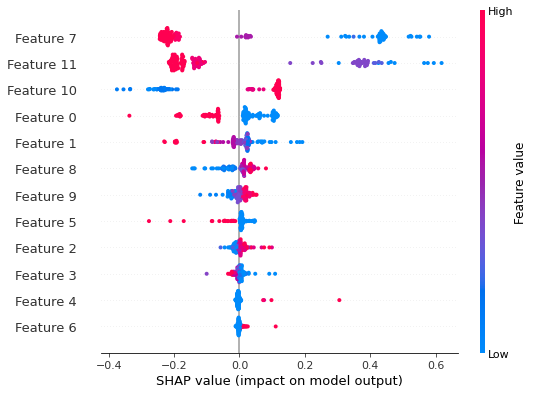

In [ ]:
shap.summary_plot(shap_values, X_sample)

### The collective force plot

In [ ]:
shap.force_plot(explainer.expected_value, shap_values, X_sample)

## Non linear SVM

In [ ]:
explainer = shap.KernelExplainer(rbf_tuned.predict,X_sample)
shap_values = explainer.shap_values(X_sample)

Using 150 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


### The summary plot

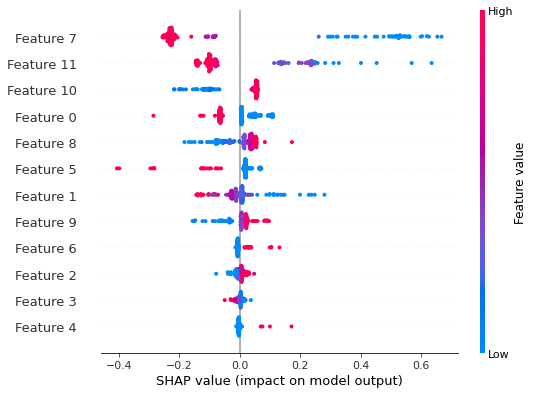

In [ ]:
shap.summary_plot(shap_values, X_sample)

### Thme Collective force plot

In [ ]:
shap.force_plot(explainer.expected_value, shap_values, X_sample)